# Azure machine learning implementation of emotion classifier

In [206]:
from azureml.core import Workspace, Experiment, Environment, ScriptRunConfig, Dataset, Run
from azureml.data.datapath import DataPath

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import os, shutil, glob

In [2]:
# Get reference to azureml workspace and retreve default datastore

ws = Workspace.from_config()

default_datastore = ws.get_default_datastore()

## Data preparation

In [76]:
from sklearn.model_selection import train_test_split

# Separate test data !

def train_val_test_split():
    
    paths = glob.glob('data/ravdess-audio-files/*/*.wav')
    
    x_train, x_test = train_test_split(paths, test_size=0.1, stratify=[int(path.split('-')[4]) for path in paths], random_state=11)
    
    print('Creating folders....\n')
    
    os.makedirs('data/training', exist_ok=True)
    print('Training created')
    
    os.makedirs('data/test', exist_ok=True)
    print('Test created\n')
    
    print('====================================\n')
    
    print('Copying files....\n')
    for path in x_train:
        shutil.copyfile(path, os.path.join('data/training', path.split('\\')[-1]))
    print('Training copied')
    
    for path in x_test:
        shutil.copyfile(path, os.path.join('data/test', path.split('\\')[-1]))
    print('Test copied\n')
    
    print('============== END ================')
    
train_val_test_split()

Creating folders....

Training created
Test created


Copying files....

Training copied
Test copied

============== END ================


In [ ]:
# Upload training and test audio files from local file system to default blob storage

Dataset.File.upload_directory(src_dir='data/training', 
                              target=DataPath(datastore=default_datastore, path_on_datastore='data/training'), overwrite=True)
Dataset.File.upload_directory(src_dir='data/test',
                              target=DataPath(datastore=default_datastore, path_on_datastore='data/test'), overwrite=True)


In [4]:
# Create training and test datasets and register them for training and inference.

training_ds = Dataset.File.from_files(path=(default_datastore, 'data/training/*.wav'))
test_ds = Dataset.File.from_files(path=(default_datastore, 'data/test/*.wav'))

try:
    training_ds = training_ds.register(workspace=ws, 
                            name='training dataset',
                            description='training audio data',
                            tags = {'format':'WAV'},
                            create_new_version=True)
    print('Training dataset registered.')
except Exception as ex:
    print(ex)
    
try:
    test_ds = test_ds.register(workspace=ws, 
                            name='test dataset',
                            description='test audio data',
                            tags = {'format':'WAV'},
                            create_new_version=True)
    print('Testing dataset registered.')
except Exception as ex:
    print(ex)

Training dataset registered.
Testing dataset registered.


## Training default model

In [7]:
training_folder = 'training_scripts'
os.makedirs(training_folder, exist_ok=True)

Create training script for training experiment.

In [203]:
%%writefile training_scripts/train_script.py

from azureml.core import Run

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.data import AUTOTUNE

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print(gpu_devices)
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten,
                                     Conv2D, MaxPooling2D, BatchNormalization,
                                     LayerNormalization, concatenate, Cropping2D)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from kapre.composed import get_melspectrogram_layer
from kapre.signal import LogmelToMFCC

import numpy as np

import argparse, glob, joblib

# ======================================================================
# ==================== Parse script arguments ==========================
# ======================================================================


run = Run.get_context()

parser = argparse.ArgumentParser()
parser.add_argument('--ds', type=str, dest='ds_ref')

# CNN parameters
parser.add_argument('--filters1', type=int, default=80)
parser.add_argument('--filters2', type=int, default=112)
parser.add_argument('--filters3', type=int, default=224)
parser.add_argument('--filters4', type=int, default=256)

parser.add_argument('--kernels1', type=int, default=3)
parser.add_argument('--kernels2', type=int, default=7)
parser.add_argument('--kernels3', type=int, default=5)
parser.add_argument('--kernels4', type=int, default=3)

parser.add_argument('--dense1', type=int, default=192)
parser.add_argument('--dense2', type=int, default=192)

parser.add_argument('--dropout1', type=float, default=0.36)
parser.add_argument('--dropout2', type=float, default=0.50)

# Optimizer parameters
parser.add_argument('--lr', type=float, help='learning_rate', default=0.0001)
parser.add_argument('--bs', type=int, help='batch size', default=16)
parser.add_argument('--epochs', type=int, help='number of epochs', default=120)

args = parser.parse_args()


# ======================================================================
# ==================== Data preparation ================================
# ======================================================================


paths = glob.glob(args.ds_ref + "/*.wav")

train_paths, validation_paths = train_test_split(paths, test_size=0.1,
                                                 stratify=[int(path.split('-')[-5]) for path in paths],
                                                 random_state=11)

MAX_LENGTH = 55000
START_TRIM = 14500
AUDIO_LENGTH = MAX_LENGTH-START_TRIM

def load_audio(path):
    
    raw = tf.io.read_file(path)
    audio = tf.squeeze(tf.audio.decode_wav(raw, desired_channels=1, desired_samples=MAX_LENGTH)[0])
    audio = (audio*(1/tf.math.reduce_max(tf.abs(audio))))[START_TRIM:]
    audio = tf.expand_dims(audio, axis=-1)
    
    target = tf.strings.split(path, sep='-')[-5]
    target = tf.strings.to_number(target, tf.int32)-1
    target = tf.one_hot(target, depth=8)
    
    return (audio, target)


train_data = tf.data.Dataset.from_tensor_slices(train_paths)
train_data = (train_data.shuffle(len(train_paths))
                        .map(load_audio, num_parallel_calls=AUTOTUNE)
                        .batch(args.bs)
                        .prefetch(AUTOTUNE))

val_data = tf.data.Dataset.from_tensor_slices(validation_paths)
val_data = (val_data.map(load_audio, num_parallel_calls=AUTOTUNE)
                    .batch(len(validation_paths))
                    .prefetch(AUTOTUNE))

# ======================================================================
# ==================== Custom layers ===================================
# ======================================================================

@tf.keras.utils.register_keras_serializable()
class RandomGaussianNoise(tf.keras.layers.Layer):
    
    """
    Layer adds gaussian noise to audio as dat augmentation.
    
    prob: probability of applying noise
    stddev: Standard deviation of the added noise. Larger value adds more noise.
    
    """
    
    def __init__(self, prob=0.5, stddev=0.001, **kwargs):
        super(RandomGaussianNoise, self).__init__(**kwargs)
        self.prob = prob
        self.stddev = stddev
    
    @tf.function
    def call(self, inputs, training=None):
        
        if not training:
            return inputs
    
        if tf.less_equal(tf.random.uniform(shape=[]), tf.constant(self.prob, shape=[])):
            return inputs + tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
        else:
            return inputs
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "prob": self.prob,
            'stddev': self.stddev
        })
        return config

@tf.keras.utils.register_keras_serializable()     
class MaskingLayer(tf.keras.layers.Layer):
    
    """
    Creates frequency mask for mel-spectrograms. Standard audio data augmentation technique.
    
    prob: probability of applying a mask.
    n_freq_masks: number of mask strips. Can be overlapping.
    
    """
    
    def __init__(self, prob=0.5, n_freq_masks=1, **kwargs):
        super(MaskingLayer, self).__init__(**kwargs)
        self.prob = prob
        self.n_freq_masks = n_freq_masks
     
    def freq_mask(self, spec):
    
        shape = tf.shape(spec)

        time, freq = shape[0], shape[1]

        if tf.less_equal(tf.random.uniform(shape=[]), tf.constant(self.prob, shape=[])):                
            for _ in range(self.n_freq_masks):

                mask_start = tf.random.uniform(shape=[], minval=0, maxval=freq-(freq//4), dtype=tf.int32)
                mask_width = tf.random.uniform(shape=[], minval=2, maxval=8, dtype=tf.int32)

                mask = tf.concat((tf.ones((time, mask_start,1)),
                                  tf.zeros((time, mask_width, 1)),
                                  tf.ones((time, freq-mask_start-mask_width, 1))), axis=1)

                spec = spec*mask + tf.fill(dims=(time, freq, 1), value=-90.)*(1-mask)
            
            return spec
        return spec
        
    def call(self, specs, training=None):
        
        if not training:
            return specs
        
        return tf.map_fn(fn=self.freq_mask, elems=specs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "prob": self.prob,
            "n_freq_masks": self.n_freq_masks,
        })
        return config
    
@tf.keras.utils.register_keras_serializable()   
class MeanVarianceLayer(tf.keras.layers.Layer):
    
    """
    Calculates mean and variance of mel-spectrogram on a given axis. These are used as feature inputs in the model.
    
    Concatenates to Rank 1 feature tensor.
    """

    def __init__(self, axis=1, **kwargs):
        super(MeanVarianceLayer, self).__init__(**kwargs)
        self.axis = axis
    
    def mean_and_var(self, spec):
        
        mean = tf.math.reduce_mean(spec, axis=self.axis)
        var = tf.math.reduce_variance(spec, axis=self.axis)

        return tf.squeeze(tf.concat([mean, var], axis=0), axis=1)
    
    def call(self, specs):
        
        return tf.map_fn(fn=self.mean_and_var, elems=specs, fn_output_signature=tf.float32)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "axis": self.axis,
        })
        return config

# ======================================================================
# ==================== Custom Callbacks ================================
# ======================================================================
    
class LogsCallback(keras.callbacks.Callback):
    
    """
    Callback logs performance metrics. 
    """
    
    def __init__(self, validation_data=None):
        super(LogsCallback, self).__init__()
        
        # There is probably a way to get access to validation data without explicitly
        # giving it to the callback since it is all ready given when fit method is called
        self.validation_data = validation_data
    
    def on_train_batch_end(self, batch, logs=None):

        run.log('loss', logs['loss'])
        run.log('accuracy', logs['accuracy'])
        
        
    def on_epoch_end(self, epoch, logs=None):
        
        # Log loss, accuracy and custom f1 score at the end of each epoch
        
        x_val, y_true = next(iter(self.validation_data))      
        y_pred = np.argmax(self.model.predict(x_val), axis=-1)
              
        run.log('val_loss', logs['val_loss'])
        run.log('val_f1', f1_score(np.argmax(y_true, axis=1), y_pred, average='macro'))
        run.log('val_accuracy', logs['val_accuracy'])

        
# ======================================================================
# ==================== Model building ==================================
# ======================================================================


# I chose to build this network such that it takes an audio array as an input without any feature engineering.
# Thus most of the computing is included in the tensorflow computational graph and should benefit from GPU acceleration at least this is the hope.

# I should probably switch to using Pytorch...

def build_model():
    
    input1 = Input((AUDIO_LENGTH,1))
    
    x = RandomGaussianNoise(prob=0.5, stddev=0.002)(input1)
    x = get_melspectrogram_layer(n_fft=512, hop_length=352, return_decibel=True, sample_rate=16000)(x)
    x = MaskingLayer(prob=0.5, n_freq_masks=3)(x)
    
    x2 = MeanVarianceLayer()(x)
    
    x1 = LogmelToMFCC(20)(x)
    x1 = Cropping2D(cropping=((0,0), (1,0)))(x1)
    x1 = LayerNormalization(axis=1)(x1)

    # Convolutional section for MFCCs
    x1 = Conv2D(args.filters1, (args.kernels1, args.kernels1), activation='relu', padding='same', name='Conv1')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(args.filters2, (args.kernels2, args.kernels2), activation='relu', padding='same', name='Conv2')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(3,3))(x1)

    x1 = Conv2D(args.filters3, (args.kernels3, args.kernels3), activation='relu', padding='same', name='Conv3')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(args.filters4, (args.kernels4, args.kernels4), activation='relu', padding='same', name='Conv4')(x1)
    x1 = BatchNormalization()(x1)

    x1 = MaxPooling2D(pool_size=(3,3))(x1)
    
    x1 = Flatten()(x1)
    
    # Normalization and dense layer for Mel-spectrogram mean and variance.
    x2 = BatchNormalization()(x2)
    x2 = Dense(args.dense1, activation='relu')(x2)
    x2 = Dropout(args.dropout1)(x2)
    
    merge = concatenate([x1, x2])
        
    x = Dense(args.dense2, activation='relu')(merge)
    x = Dropout(args.dropout2)(x)
    x = Dense(8, activation='softmax')(x)

    model = Model(inputs=input1, outputs=x)
    
    return model
    
model = build_model()

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=args.lr), metrics=["accuracy"])
    
callbacks = [LogsCallback(val_data),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.000025, patience=10, verbose=1),
             EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)]

model.fit(x=train_data, validation_data=val_data, epochs=args.epochs, callbacks=callbacks)

# ======================================================================
# ==================== Model saving ====================================
# ======================================================================

# Save the trained model as an artifact on the outputs folder
os.makedirs('outputs/model', exist_ok=True)

model.save('outputs/model')

print('Model saved!')

run.complete()

Overwriting training_scripts/train_script.py


Create function for provisioning compute clusters for GPU, CPU or local jobs

In [6]:
# Create a compute cluster

def get_compute_target(cluster_name):
    
    if cluster_name == 'gpu-cluster':
        
        try:
            compute_target = ComputeTarget(workspace=ws, name=cluster_name)
            print(f'Found existing compute target with name {cluster_name}')
            
            return compute_target
        
        except ComputeTargetException:
            print('Creating a new compute target...')
            compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                                   min_nodes=0,
                                                                   max_nodes=4,
                                                                   idle_seconds_before_scaledown=120)

            compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
            compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
            
            return compute_target

    elif cluster_name == 'cpu-cluster':
        
        try:
            compute_target = ComputeTarget(workspace=ws, name=cluster_name)
            print(f'Found existing compute target with name {cluster_name}')
            
            return compute_target
        
        except ComputeTargetException:
            print('Creating a new compute target...')
            compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_F4s_v2',
                                                                   min_nodes=0,
                                                                   max_nodes=2,
                                                                   idle_seconds_before_scaledown=120)

            compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
            compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
            
            return compute_target
    
    elif cluster_name == 'local':
        print('Using local compute target')
        return 'local'


### Compute environment

Next a compute environment needs to be specified. When a job is run on a compute target a docker container is created that includes all the dependecies that the script execution needs.

For this case we need base docker image that has appropriate CUDA and cuDNN libraries installed. Custom dockerfile needs to be also specified because SoundFile package in Linux needs libsndfile1 which is not a python package and thus can't be conda or pip installed. 

In [41]:
%%writefile training_env.yml

name: test_env
channels:
 - conda-forge
 - defaults
dependencies:
 - python=3.8
 - pip=20.2.4
 - pip:
    - numpy==1.22
    - scikit-learn==1.0
    - tensorflow==2.7.3
    - librosa
    - kapre
    - azureml-defaults==1.44.0   

Overwriting training_env.yml


In [ ]:
# Finally managed to build a working gpu environment for cluster...

test_env = Environment.from_conda_specification('training-env', 'training_env.yml')

# Add extra dependency for SoundFile pkg
docker = r"""
FROM mcr.microsoft.com/azureml/curated/tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu:22
RUN apt-get update && \
    apt-get install -y \
    libsndfile1
"""

test_env.docker.base_dockerfile = docker
test_env.docker.base_image = None

test_env.register(ws)

Finally running training experiment with "default" hyperparameters for model.

In [ ]:
cluster_name = 'gpu-cluster'
compute_target = get_compute_target(cluster_name)
    
training_env = Environment.get(ws, 'training-env')
    
training_ds = ws.datasets.get('training dataset')

args = ['--ds', training_ds.as_named_input('training_data').as_download('data')]

script_config = ScriptRunConfig(source_directory='training_scripts',
                                script='train_script.py',
                                arguments=args,
                                compute_target=compute_target,
                                environment=training_env)


experiment = Experiment(workspace=ws, name='tune-default-CNN')
run = experiment.submit(config=script_config)

run.get_portal_url()

After training the model is registered.

In [ ]:
run.register_model('Emotion-classifier', model_path='outputs/model',
                   properties={'min_val_loss': min(run.get_metrics()['val_loss']),
                               'max_val_accuracy': max(run.get_metrics()['val_accuracy']),
                               'max_val_f1': max(run.get_metrics()['val_f1'])})

## Deployment as a batch inferencing service

In this section the first model is deployed to batch endpoint. Test set data is processed in parallel in batches and predicton results are generated. The batch pipeline can be submitted to execute explicitly or with a REST call over http.

The test set has only 144 samples so this deployment method is of course very impractical in this particular case. This was done only as to learn to implement such service.

The model could be also easily deployed as real-time Azure kubernetes inference service for production loads.

In [182]:
from azureml.pipeline.steps import ParallelRunConfig, ParallelRunStep
from azureml.data import OutputFileDatasetConfig
from azureml.pipeline.core import Pipeline, PublishedPipeline, PipelineParameter
from azureml.core.model import Model

In [90]:
deployment_folder = 'inference_scripts'
os.makedirs(deployment_folder, exist_ok=True)

### Inference enviroment

In [20]:
%%writefile inference_env.yml

name: test_env
channels:
 - conda-forge
 - defaults
dependencies:
 - python=3.8
 - numpy=1.22
 - pip=20.2.4
 - pip:
    - azureml-defaults
    - tensorflow

Overwriting inference_env.yml


In [ ]:
%%writefile inference_scripts/batch_inference.py

from azureml.core.model import Model

import tensorflow as tf

import numpy as np
import os

# ParallelRunStep needs to implement init and run functions.
# Init is the first function to get executed and run is executed by a child node resiving a mini-batch of data.

def init():
    global model
    
    model_path = Model.get_model_path('Emotion-classifier')
    model = tf.keras.models.load_model(model_path)

def run(mini_batch):
    
    inference_results = []

    # process batch
    for file_path in mini_batch:
        
        audio, target = load_audio(file_path)
    
        y_pred = np.argmax(model.predict(audio), axis=-1)[0]
        
        inference_results.append('{}: {}: {}'.format(os.path.basename(file_path), np.argmax(target, axis=0), y_pred))
        
    return inference_results


def load_audio(path):
    
    MAX_LENGTH = 55000
    START_TRIM = 14500
    AUDIO_LENGTH = MAX_LENGTH-START_TRIM

    raw = tf.io.read_file(path)
    audio = tf.audio.decode_wav(raw, desired_channels=1, desired_samples=MAX_LENGTH)[0]
    audio = (audio*(1/tf.math.reduce_max(tf.abs(audio))))[START_TRIM:]
    audio = tf.expand_dims(audio, axis=0)

    target = tf.strings.split(path, sep='-')[-5]
    target = tf.strings.to_number(target, tf.int32)-1
    target = tf.one_hot(target, depth=8)

    return (audio, target)

Overwriting inference_scripts/batch_inference.py


In [ ]:
# Define batch inference pipeline configuration

test_ds = ws.datasets['test dataset']

outputs_folder = OutputFileDatasetConfig(name='inferences')

inference_env = Environment.from_conda_specification('inference_env', 'inference_env.yml')

cluster_name = 'cpu-cluster'
compute_target = get_compute_target(cluster_name=cluster_name)

parallel_run_config = ParallelRunConfig(
    source_directory='inference_scripts',
    entry_script="batch_inference.py",
    error_threshold=0,
    mini_batch_size="36",
    output_action="append_row",
    environment=inference_env,
    compute_target=compute_target,
    node_count=4)

parallel_run_step = ParallelRunStep(name='batch-inference',
                                    parallel_run_config=parallel_run_config,
                                    inputs=[test_ds.as_named_input('test_dataset')],
                                    output=outputs_folder,
                                    allow_reuse=False)

inference_pipe = Pipeline(workspace=ws, steps=[parallel_run_step])

# Publish pipeline as a REST service. When REST endpoint is called it begins a pipeline run.
inference_pipe.publish('batch-inference-pipeline', description='Batch score emotion-classifier test data')

In [ ]:
# Submit pipeline job to a cluster as an experiment

pipe_run = Experiment(workspace=ws, name='batch-inference-pipeline').submit(inference_pipe)
pipe_run.wait_for_completion(show_output=True)


### Inference results

Retrieve results that were genereated by the batch inferencing pipeline

In [121]:
def get_inference_results(local_path, pipe_run=None):
    
    if pipe_run is not None:
        
        # Get inference step and load results folder to some local path
        inference_run = next(pipe_run.get_children())
        inference_output = inference_run.get_output_data('inferences')
        inference_output.download(local_path=local_path)

    result_file = ''
    
    # Find parallel_run_step.txt
    for root, dirs, files in os.walk(local_path):
        for file in files:
            if file.endswith('parallel_run_step.txt'):
                result_file = os.path.join(root,file)
    
    # Create pandas dataframe from parallel_run_step.txt
    df = pd.read_csv(result_file, delimiter=":", names=['File path', 'True label', 'Predicted label'])
    
    return df

def display_metrics(df, cm_name):    
    
    # Calculate accuracy
    print(f"\nModel accuracy: {round(accuracy_score(df['True label'], df['Predicted label']), 4)}\n")

    labels = ['neutral',
              'calm',
              'happy',
              'sad',
              'angry',
              'fearul',
              'disgust',
              'surprised']

    # Display confusion matrix
    cm = ConfusionMatrixDisplay.from_predictions(df['True label'], df['Predicted label'], display_labels=labels, cmap='copper', xticks_rotation=20)
    plt.title(cm_name, y=1.02)
    plt.tight_layout()
    plt.show()
    

Show accuracy and confusion matrix


Model accuracy: 0.5208



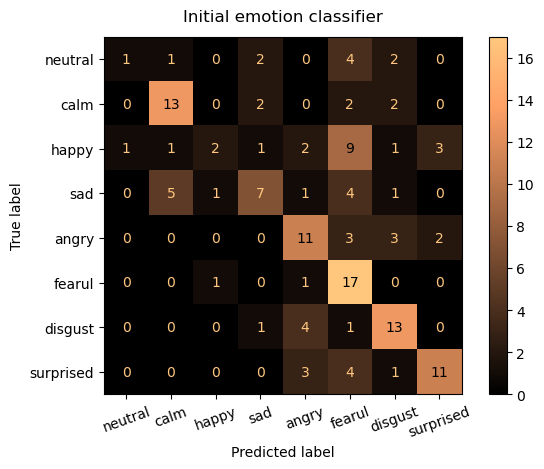

In [122]:
display_metrics(inference_results(local_path='results/default_inference_results'), cm_name='Initial emotion classifier')

## Hyperparameter tuning

In [78]:
from azureml.train.hyperdrive import (RandomParameterSampling, BayesianParameterSampling,
                                      HyperDriveConfig, PrimaryMetricGoal, BanditPolicy,
                                      choice, uniform)

In [ ]:
cluster_name = 'gpu-cluster'
compute_target = get_compute_target(cluster_name)

# Retrieve the environment that was used for training
tuning_env = Environment.get(ws, 'training-env')

training_ds = ws.datasets.get('training dataset')

# Static script arguments
args = ['--ds', training_ds.as_named_input('training_data').as_download('data'),
        '--lr', 0.0001,
        '--bs', 16,
        '--epochs', 120]


# Tunable parameters
# Good approch is to warm start bayesian sampling with initial random sampling to populate the hyperparameter space
# This would lessen the probability for the bayesian optimizer to find and stay in some local optimum

params_dict = {'--filters1': choice([32+(16*i) for i in range(7)]),
               '--filters2': choice([32+(16*i) for i in range(7)]),
               '--filters3': choice([96+(32*i) for i in range(6)]),
               '--filters4': choice([96+(32*i) for i in range(6)]),

               '--kernels1': choice(3, 5, 7),
               '--kernels2': choice(3, 5, 7),
               '--kernels3': choice(3, 5, 7),
               '--kernels4': choice(3, 5, 7),

               '--dense1': choice([128+(64*i) for i in range(7)]),
               '--dense2': choice([128+(64*i) for i in range(7)]),

               '--dropout1': uniform(0.2, 0.75),
               '--dropout2': uniform(0.2, 0.75),
         }

params_random = RandomParameterSampling(params_dict)

params_bayesian = BayesianParameterSampling(params_dict)
        
script_config = ScriptRunConfig(source_directory='training_scripts',
                                script='tune_script.py',
                                arguments=args,
                                compute_target=compute_target,
                                environment=tuning_env)

# Use older run as warm start. Random sampling, 40 hyperparameters sampled.
hyperdrive1 = Run.get(ws, run_id='HD_d5dc7cf9-1e10-484c-879d-4ef3a0b37c6c')

hyperdrive_random_config = HyperDriveConfig(run_config=script_config, 
                                             hyperparameter_sampling=params_random, 
                                             policy=BanditPolicy(evaluation_interval=2, delay_evaluation=60, slack_amount=0.2),
                                             primary_metric_name='val_loss',
                                             primary_metric_goal=PrimaryMetricGoal.MINIMIZE, 
                                             max_total_runs=40,
                                             max_concurrent_runs=1,
                                             resume_from=hyperdrive1)

hyperdrive2 = Experiment(workspace=ws, name='tune-default-CNN').submit(config=hyperdrive_random_config)
hyperdrive2.wait_for_completion()

hyperdrive_bayesian_config = HyperDriveConfig(run_config=script_config, 
                                              hyperparameter_sampling=params_bayesian, 
                                              primary_metric_name='val_loss',
                                              primary_metric_goal=PrimaryMetricGoal.MINIMIZE, 
                                              max_total_runs=40,
                                              max_concurrent_runs=1,
                                              resume_from=[hyperdrive1, hyperdrive2])

hyperdrive_final = Experiment(workspace=ws, name='tune-default-CNN').submit(config=hyperdrive_bayesian_config)
hyperdrive_final.wait_for_completion()

Hyperdrive runs can be monitored conveniently from Azure ml studio. Best performing model can be chosen from the trials and registered as the latest version of the inital model. This way the batch inferencing pipeline automatically uses the latest and best version of the model when called to run.

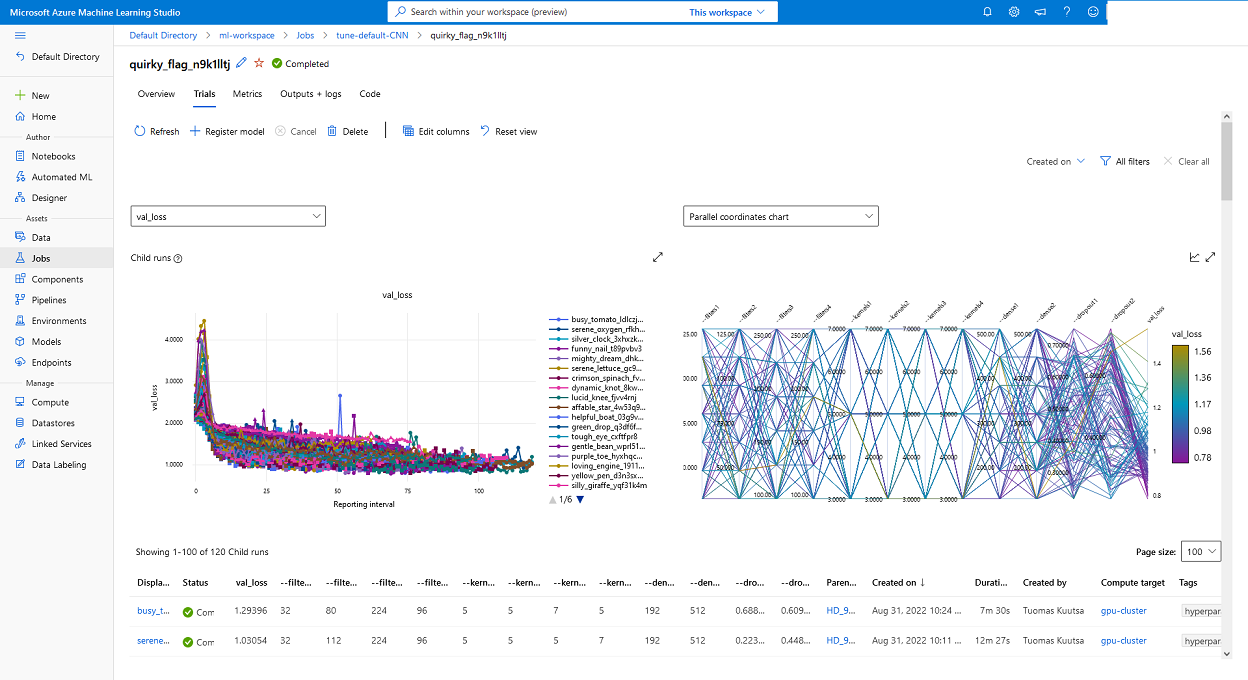

In [207]:
Image('images/hyperdriveruns.png')

Child runs can also be retrieved from the hyperdrive run object and the best model registered using the SDK.

In [135]:
import json

tuning_experiment = Experiment(workspace=ws, name='tune-default-CNN')

hyperdrive_final = next(tuning_experiment.get_runs())

# # Inspecting 5 best performing models.

best_trials = hyperdrive_final.get_children_sorted_by_primary_metric(top=10)

hp_dataframe = pd.DataFrame([json.loads(trial['hyperparameters']) for trial in best_trials])

hp_dataframe['validation loss'] = pd.Series(trial['best_primary_metric'] for trial in best_trials)

hp_dataframe

For best results with Bayesian Sampling we recommend using a maximum number of runs greater than or equal to 20 times the number of hyperparameters being tuned. Recommendend value:240.


,--filters1,--filters2,--filters3,--filters4,--kernels1,--kernels2,--kernels3,--kernels4,--dense1,--dense2,--dropout1,--dropout2,validation loss
0,80,112,224,256,3,7,5,3,192,192,0.362658,0.472942,0.781977
1,32,96,224,96,3,7,7,5,192,512,0.380678,0.700066,0.794992
2,80,128,160,224,3,5,7,7,512,320,0.444695,0.749786,0.796714
3,48,96,96,128,7,3,5,5,192,256,0.436863,0.658607,0.802228
4,128,80,256,224,5,5,3,7,256,192,0.749960,0.672213,0.822229
5,32,80,224,96,5,5,7,5,192,512,0.688184,0.609994,0.853369
6,128,96,192,224,7,5,5,5,192,448,0.634652,0.316358,0.865633
7,32,112,224,96,5,5,5,7,192,512,0.223674,0.448722,0.867788
8,64,64,192,160,7,5,7,5,192,128,0.267740,0.495575,0.868055
9,48,128,160,160,3,7,3,3,256,256,0.658227,0.598399,0.876818


In [106]:
# Register the best model

best_trial = hyperdrive_final.get_best_run_by_primary_metric()

best_trial.register_model('Emotion-classifier', model_path='outputs/model',
                          description='hyperparameter tuned emotion classifier',
                          properties={'min_val_loss': min(best_trial.get_metrics()['val_loss']),
                                      'max_val_accuracy': max(best_trial.get_metrics()['val_accuracy']),
                                      'max_val_f1': max(best_trial.get_metrics()['val_f1'])})

From the studio we can see that a new version of the model has been created.

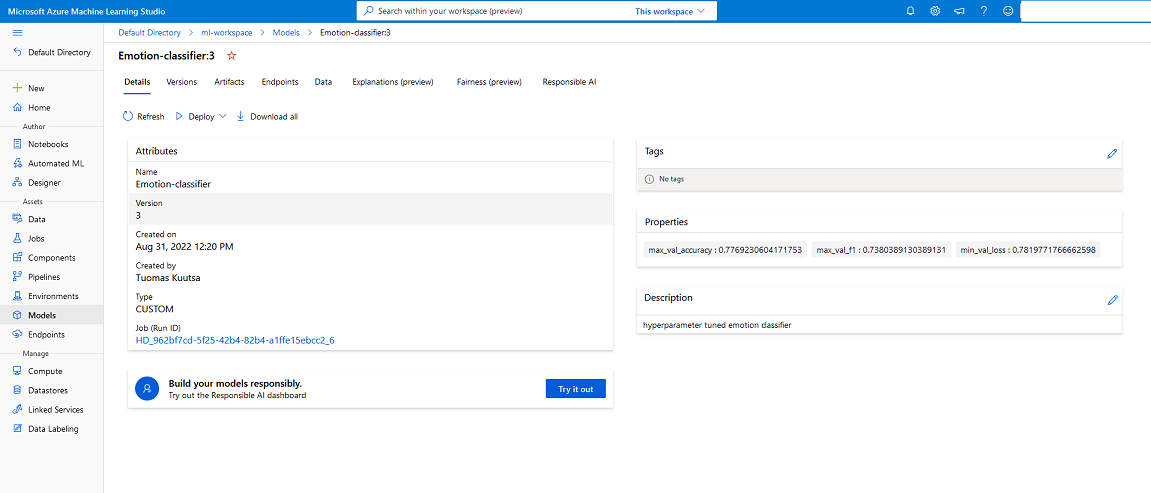

In [208]:
Image('images/best_model.png')

The run that generated the model can also be shown.

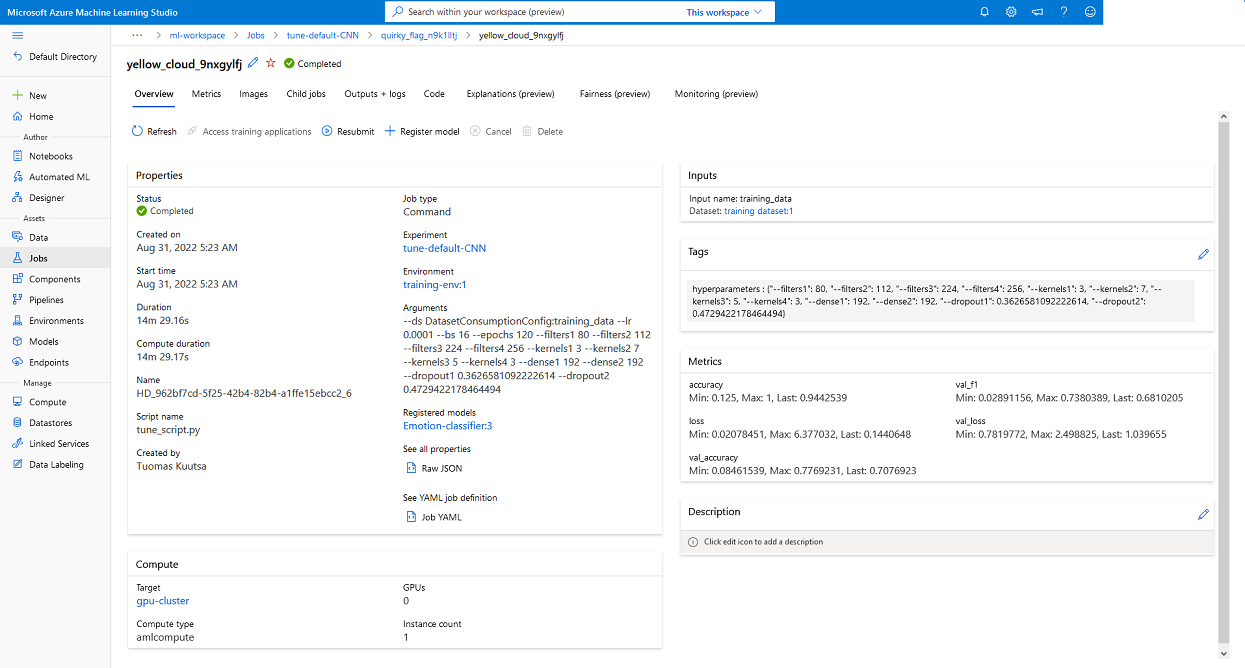

In [209]:
Image('images/best_trial_details.png')

And chosen metrics for the run.


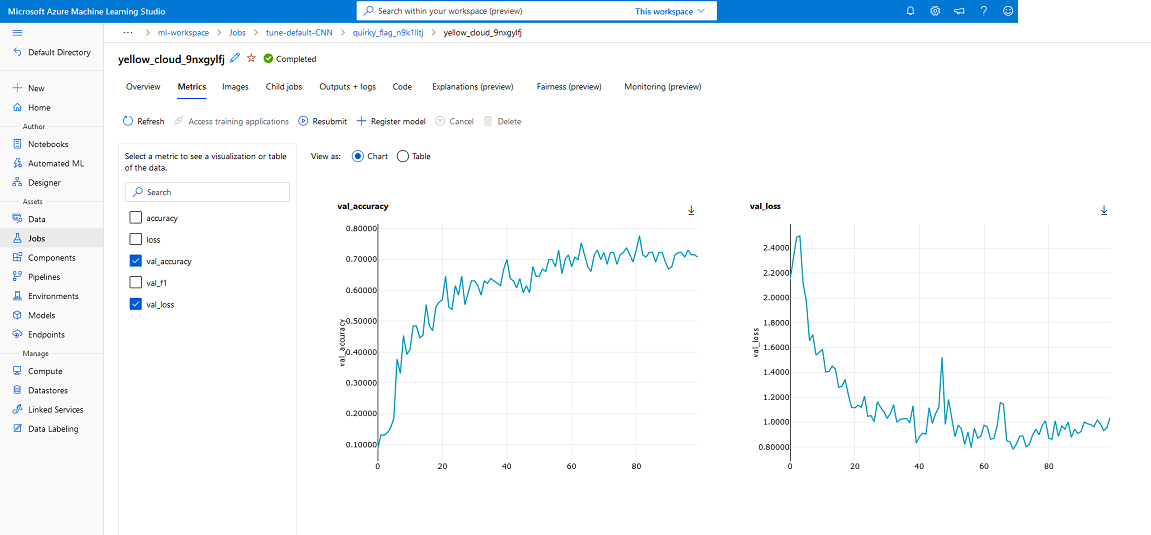

In [210]:
Image('images/best_trial_metrics.png')

### Batch inference of tuned classifier

Last thing is to launch a batch inference pipeline using the new version of the model by making a http request to the pipeline REST endpoint.

Note that a compute target that was specified in the pipelines ParallelStepConfig needs to be provisioned in the workspace for the run take place.

This can take some time if the docker image is not cached and needs to be pulled from container repository.

In [ ]:
from azureml.core.authentication import InteractiveLoginAuthentication

import requests

# Retrieve pipelines REST endpoint.
inference_endpoint = PublishedPipeline.list(ws)[0].endpoint

# Create authentication header for the post request.
auth_header = InteractiveLoginAuthentication().get_authentication_header()

response = requests.post(inference_endpoint,
                         headers=auth_header,
                         json={"ExperimentName": "batch-inference-pipeline",
                               "RunSource": "SDK"})
# Get run id
run_id = response.json()["Id"]

# Get the pipeline run object using run id
pipe_run = Run.get(workspace=ws, run_id=run_id)
pipe_run.get_portal_url()

### Inference results

Using the pipeline run object download inference results and display new accuracy and confusion matrix.


Model accuracy: 0.75



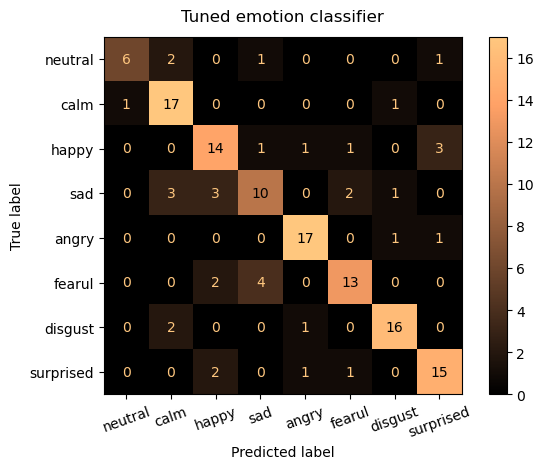

In [202]:
display_metrics(df=get_inference_results(local_path='results/tuned_inference_results', pipe_run=pipe_run), cm_name='Tuned emotion classifier')

It has to be said that in this notebook all Azure resources are not securely inside a VNet. In production this should of course be configured.